In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string
import unidecode
import time, math
import random

# Used by the model
import torch
import torch.nn as nn
from torch.autograd import Variable
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu

# For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Prevent kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Loading The Data

In [2]:
# Reads the data
labeledPfd = pd.read_csv("./datasets/LabeledPoetryFoundationPoems.csv")
labeledPfd = labeledPfd.sample(frac=1) # randomizes the data

# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

# Processing the Data

## The Batch Generator

In [3]:
class BatchGenerator(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.outputs = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.outputs[index]

## The Data Processor

In [4]:
punctuation = " .,;?\"\n"
class DataProcessor:
    def __init__(self, dataset, batch_size=48):
        full_data = list(dataset)
        
        # first 20% as test data
        twentyPercent = math.ceil(len(full_data) * 0.2)
        self.test_set = full_data[:twentyPercent]
        # last 80% as train data
        eigtyPercent = math.floor(len(full_data) * 0.8)
        full_data = full_data[-eigtyPercent:]

        def joinStrings(text):
            return '\n'.join(string for string in text)
        full_data = joinStrings(full_data)

        # Clean the data
        # Removes punctuation from the dataset
        self.clean_data = [word for word in nltk.word_tokenize(full_data) if (word.isalnum() or word in punctuation)]
        # print("Number of tokens:", len(clean_data)) # Number of tokens
        # print(clean_data[:10])

        # Extracts the vocabulary
        self.vocab = set(self.clean_data)
        self.voc_len = len(self.vocab)

        # Encodes the position of each word in the vocabulary
        self.word_to_ix = {word: i for i, word in enumerate(self.vocab)}

        # Generates trigram word embeddings
        # with the data. For the sentence:
        # "I party with my friends on the weekends"
        # "with", and "my" will be the context for
        # the word "friends". An example is printed bellow
        self.embeddings = [
            ([trigram[0], trigram[1]], trigram[2]) for trigram in ngrams(self.clean_data, 3)
        ]
        self.num_embeddings = len(self.embeddings)
        
        # Training and Testing sets ready to be used
        self.train_set = BatchGenerator(*self.inp_tar_pairs())
        
    def inp_tar_pairs(self):
        inputs = []
        targets = []
        
        for context, target in self.embeddings:
            # 2dim tensor with the positions of the context letters
            context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long)
            inputs.append(context_idxs)

            # 1dim tensor with the position of the target letter
            targ = torch.tensor([self.word_to_ix[target]], dtype=torch.long)
            targets.append(targ)
            
        return inputs, targets 

# The Recurrent Neural Network (GRU)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        # We are using the GRU method to train the model
        self.gru = nn.GRU(
            hidden_size * 2,
            hidden_size,
            n_layers,
            batch_first = True, # x: (num_embeddings, context_size, input_size)
            bidirectional = False
        )
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_vect, hidden):
        input_vect = self.encoder(input_vect.view(1, -1)) # flattens the input vector
        output, hidden = self.gru(input_vect.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
    
    def trainer(self, model, train_set):
        """
        Trains the model with the data for
        the equivalent of 1 epoch
        """
        
        # Initializes the hidden state
        hidden = self.init_hidden()

        # Initializes the gradients and the loss
        self.zero_grad()
        loss = 0

        # Trains the neural network over all
        # the character embeddings
        for inp, tar in train_set:
            # The model taken in a context tensor, and
            # the previous hidden state to predict an
            # output, and compute a new hidden state
            output, hidden = self.forward(inp, hidden)

            # The loss is computed using the predicted output
            # and the target (expected output)
            loss += model.criterion(output, tar)

        # Propagates the loss backwards
        # through the network
        loss.backward()
        model.model_optimizer.step()

        # Returns the loss of the network
        return loss.data.item() / model.data.num_embeddings

# The Model Class

In [31]:
class PoemModel:
    def __init__(self, data):
        self.data = data
        
        # Model Hyperparameters
        self.n_epochs      = 10
        self.print_every   = 1
        self.plot_every    = 1
        self.hidden_size   = 120
        self.n_layers      = 3
        self.learning_rate = 0.01
        self.batch_size    = 32
        
        # RNN Initialization
        self.model = RNN(data.voc_len, self.hidden_size, data.voc_len, self.n_layers)
        self.model_optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
    
    
    def train(self, plot_loss=True):
        total_time_start = time.time()
        all_losses = []
        loss_avg = 0

        # Converts the execution time
        # to a human-readible format
        def time_since(since):
            s = time.time() - since
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        
        print("Started training...")
            
        # Trains the model.
        # n_epochs determines how many times we
        # will show the same data to the network.
        for epoch in range(1, self.n_epochs + 1):
            start = time.time()
            
            # Divides the entire dataset into [batch_size] batches
            training_generator = torch.utils.data.DataLoader(self.data.train_set, 
                batch_size = self.batch_size,
                shuffle = True,
            )
            training_generator = iter(training_generator)
            
            # Only trains using [batch_size] of the generated batches.
            # So if there were a total of 500 batches, and our batch_size
            # equals 20, then it will only train with 20 batches of 20 pairs
            batch_index = 0
            for index in range(self.batch_size):
                batch_index += 1
                print("Running batch #" + str(batch_index) + " out of " + str(self.batch_size), end="\r")
                
                # Trains the model for the
                # current epoch
                inp, tar = training_generator.next()
                loss = self.model.trainer(self, zip(inp, tar))  
                loss_avg += loss

            # Logs out the epoch execution time
            if epoch % self.print_every == 0:
                print('Epoch #%d (%d%%) [Exc. Time: %s, Loss: %.4f]' % (
                    epoch, epoch / self.n_epochs * 100, time_since(start), loss
                ))

            # Saves the epoch execution time for later plotting
            if epoch % self.plot_every == 0:
                all_losses.append(loss_avg / self.plot_every)
                loss_avg = 0

        # Prints the total time taken by training the model
        print("\nTotal training time:", time_since(total_time_start))
        
        # Plots the loss
        if plot_loss:
            plt.figure()
            plt.plot(all_losses)
        
        
    def generate(self, prime_str, predict_len=100, temperature=0.8):
        hidden = self.model.init_hidden()

        for p in range(predict_len):
            prime_input = torch.tensor([self.data.word_to_ix[w] for w in prime_str.split()], dtype=torch.long)
            inp = prime_input[-2:] #last two words as input
            output, hidden = self.model.forward(inp, hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted word to string and use as next input
            predicted_word = list(self.data.word_to_ix.keys())[list(self.data.word_to_ix.values()).index(top_i)]
            prime_str += " " + predicted_word

        return prime_str
    
    def evaluate_model(self):
        rouge = Rouge()
        
        # Selects the first 10 poems of the
        # test set to test the model
        first_10 = self.data.test_set[:10]
        
        # cleans a peom
        def clean_poem(poem):
            return [word for word in nltk.word_tokenize(poem) if (word.isalnum() and word in self.data.vocab)]
        
        # list of poems with clean data as hypothesis for ROUGE
        rouge_hyp = [" ".join(clean_poem(poem)) for poem in first_10]
        rouge_refs = []
        
        # list of lists of poems with clean data as hypothesis for BLEU
        bleu_references = [clean_poem(poem) for poem in first_10]
        bleu_candidates = []

        for i in range(10):
            first_two_words = " ".join(rouge_hyp[i].split(" ")[:2])
            gen_poem = self.generate(first_two_words)
            gen_poem = [word for word in nltk.word_tokenize(gen_poem)]
            
            # for rouge
            rouge_refs.append(" ".join(gen_poem))
            
            # for bleu
            bleu_candidates.append(gen_poem)

        rouge_scores = rouge.get_scores(rouge_hyp, rouge_refs, avg=True)
        print("ROUGE SCORE:", rouge_scores)
        
        bleu_score = corpus_bleu(bleu_references, bleu_candidates)
        print("\nBLEU SCORE:", bleu_score)

# The Model for the "Joy" Category

In [33]:
joyData = DataProcessor(poems["joy"][:2000])

Started training...
Epoch #1 (10%) [Exc. Time: 0m 20s, Loss: 0.0007]
Epoch #2 (20%) [Exc. Time: 0m 20s, Loss: 0.0006]
Epoch #3 (30%) [Exc. Time: 0m 20s, Loss: 0.0006]
Epoch #4 (40%) [Exc. Time: 0m 20s, Loss: 0.0007]
Epoch #5 (50%) [Exc. Time: 0m 20s, Loss: 0.0006]
Epoch #6 (60%) [Exc. Time: 0m 20s, Loss: 0.0007]
Epoch #7 (70%) [Exc. Time: 0m 20s, Loss: 0.0006]
Epoch #8 (80%) [Exc. Time: 0m 20s, Loss: 0.0005]
Epoch #9 (90%) [Exc. Time: 0m 20s, Loss: 0.0006]
Epoch #10 (100%) [Exc. Time: 0m 20s, Loss: 0.0006]

Total training time: 3m 24s


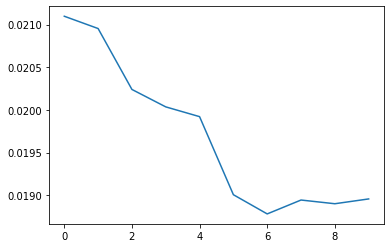

In [34]:
m = PoemModel(joyData)
m.train()

In [35]:
m.generate("Oh boy")

'Oh boy , a thou , goodies canal this she , When , The its they dancers thou the window . in she , be , I , behind There too with would . a falls , fox not , ? . , , . . seemed skin , power love a my the remarkable moonshine of , a , , i all while wine , . How godly , almost , The , and , music call ; snow is . With their thou , by . , d I were a by the they s dark of , The ,'

In [36]:
m.evaluate_model()

ROUGE SCORE: {'rouge-1': {'f': 0.1635004547866158, 'p': 0.17920632873518744, 'r': 0.23868681183813734}, 'rouge-2': {'f': 0.011146235234880023, 'p': 0.015257121704565035, 'r': 0.014530968255534182}, 'rouge-l': {'f': 0.14552002342027948, 'p': 0.14526434798716897, 'r': 0.22030759888640442}}

BLEU SCORE: 8.003946549955478e-232


/Users/faustotnc/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
